# Model tuning

### Prepare the Training Set

In [1]:
import numpy as np
import pandas as pd

#Load all training data
X_train = pd.read_csv('Inputs\\train_test_sets\\training.csv')
y_train = X_train.pop('Label')
print(X_train.shape)

(999856, 71)


In [2]:
from sklearn.calibration import LabelEncoder

#drop features that are not required
features_to_drop = ['Protocol', 'Dst Port Class']
X_train.drop(axis=1, columns=features_to_drop, inplace=True)

In [3]:
from collections import Counter
Counter(y_train)

Counter({'DoS attacks-Hulk': 164962,
         'DDOS attack-HOIC': 156456,
         'DDoS attacks-LOIC-HTTP': 151250,
         'Bot': 129813,
         'Benign': 121965,
         'Infilteration': 120476,
         'SSH-Bruteforce': 84521,
         'DoS attacks-GoldenEye': 31131,
         'FTP-BruteForce': 29045,
         'DoS attacks-Slowloris': 8243,
         'DDOS attack-LOIC-UDP': 1298,
         'Brute Force -Web': 458,
         'Brute Force -XSS': 173,
         'SQL Injection': 65})

In [27]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

#Define the over sampling and under sampling dictionaries
dictUnderSample = { 'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 31131,
                    'FTP-BruteForce': 29045,
                    'DoS attacks-Slowloris': 8243,
                    'DDOS attack-LOIC-UDP': 1298,
                    'Brute Force -Web': 458,
                    'Brute Force -XSS': 173,
                    'SQL Injection': 65}

dictOverSample = {  'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 50000,
                    'FTP-BruteForce': 50000,
                    'DoS attacks-Slowloris': 50000,
                    'DDOS attack-LOIC-UDP': 50000,
                    'Brute Force -Web': 50000,
                    'Brute Force -XSS': 50000,
                    'SQL Injection': 50000}

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
print(len(X_train2))
y_train2.value_counts()

679045


Label
Benign                    50000
Bot                       50000
Brute Force -Web          50000
Brute Force -XSS          50000
DDOS attack-HOIC          50000
DDOS attack-LOIC-UDP      50000
DDoS attacks-LOIC-HTTP    50000
DoS attacks-GoldenEye     50000
DoS attacks-Hulk          50000
DoS attacks-Slowloris     50000
Infilteration             50000
SQL Injection             50000
SSH-Bruteforce            50000
FTP-BruteForce            29045
Name: count, dtype: int64

## Hyper-tuning of classifier

In [33]:
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import StratifiedKFold

#Use GridSearch cross-validation to find optimum parameters
cv = StratifiedKFold(n_splits=4, shuffle=True)
f2_scorer = make_scorer(fbeta_score, beta=2, average='macro')

#Define Optuna objective method
def objective(trial, X, y, cv, scoring):
    param_grid = {
        #"n_estimators": trial.suggest_int("n_estimators", 20, 250),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.4),
        "num_leaves": trial.suggest_int("num_leaves", 20, 250),
        # "early_stopping_rounds": 10,
        #"max_depth": trial.suggest_int("max_depth", 3, 15),
        "max_bin": trial.suggest_int("max_bin", 50, 450, step=50),
        "boosting_type": trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100),
        # "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 2),
        # "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)
        "objective": 'multiclass', 
        "verbose": -1,
        #"random_state": 0
    }

    clf = LGBMClassifier(**param_grid)
    cv_scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring, n_jobs=5)
    return cv_scores.mean()

#Initialise the Optuna study
study = optuna.create_study(direction="maximize", study_name='Hyperparameter Tuning')       #We want to maximise the F2 scores

#Optimization with several trials
func = lambda trial: objective(trial, X_train2, y_train2, cv=cv, scoring=f2_scorer)
study.optimize(func, n_trials=10)

#Output results
trial = study.best_trial
print("Best F2-macro score (mean): ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))


[I 2024-01-21 00:26:20,514] A new study created in memory with name: Hyperparameter Tuning
[I 2024-01-21 00:27:42,628] Trial 0 finished with value: 0.9791409800090041 and parameters: {'learning_rate': 0.32149316276591355, 'num_leaves': 84, 'max_bin': 350, 'boosting_type': 'dart', 'lambda_l1': 53, 'bagging_fraction': 0.7676467054891687, 'bagging_freq': 0}. Best is trial 0 with value: 0.9791409800090041.
[I 2024-01-21 00:28:53,561] Trial 1 finished with value: 0.9774404341099526 and parameters: {'learning_rate': 0.057419764666741736, 'num_leaves': 210, 'max_bin': 350, 'boosting_type': 'dart', 'lambda_l1': 11, 'bagging_fraction': 0.2622580858246709, 'bagging_freq': 2}. Best is trial 0 with value: 0.9791409800090041.
[I 2024-01-21 00:29:47,370] Trial 2 finished with value: 0.9809196830558643 and parameters: {'learning_rate': 0.1158766943612183, 'num_leaves': 152, 'max_bin': 400, 'boosting_type': 'gbdt', 'lambda_l1': 17, 'bagging_fraction': 0.8074313468720595, 'bagging_freq': 0}. Best is tr

Best F2-macro score (mean):  0.9809196830558643
Best Params: 
  learning_rate: 0.1158766943612183
  num_leaves: 152
  max_bin: 400
  boosting_type: gbdt
  lambda_l1: 17
  bagging_fraction: 0.8074313468720595
  bagging_freq: 0


In [6]:
optuna.visualization.plot_param_importances(study)

## Execute the model on Testing Set

In [18]:
from collections import Counter
Counter(y_train2)

Counter({'Benign': 50000,
         'Bot': 50000,
         'Brute Force -Web': 50000,
         'Brute Force -XSS': 50000,
         'DDOS attack-HOIC': 50000,
         'DDOS attack-LOIC-UDP': 50000,
         'DDoS attacks-LOIC-HTTP': 50000,
         'DoS attacks-GoldenEye': 50000,
         'DoS attacks-Hulk': 50000,
         'DoS attacks-Slowloris': 50000,
         'Infilteration': 50000,
         'SQL Injection': 50000,
         'SSH-Bruteforce': 50000,
         'FTP-BruteForce': 29045})

In [19]:
from CustomFunctions import Timer
clf = LGBMClassifier(boosting_type='gbdt', objective='multiclass', n_jobs=-1, verbose=-1,
                     n_estimators=100, num_leaves=152, learning_rate=0.1158, max_bin=400,
                    bagging_fraction=0.807, bagging_freq=0)

#First fit the model
t = Timer()
t.start()
clf.fit(X_train2, y_train2)
t.stop(timerName='Training of model')

Training of model took 37.44 seconds (396.75 CPU seconds)


In [20]:
from sklearn.calibration import LabelEncoder

#Load all testing data
X_test = pd.read_csv('Inputs\\train_test_sets\\testing.csv')
y_test = X_test.pop('Label')

#drop features that are not required
features_to_drop = ['Protocol', 'Dst Port Class']
X_test.drop(axis=1, columns=features_to_drop, inplace=True)
print(X_test.shape)

(1499016, 69)


In [21]:
t = Timer()
t.start()
pred_test_1000 = clf.predict(X_test.head(1000))
t.stop('Executing model over the first 1000 rows of Testing Set')

#Obtain predictions on the full Training dataset
pred_train = clf.predict(X_train)

#Obtain predictions on the full Testing dataset
t.start()
pred_test = clf.predict(X_test)
t.stop('Executing model over the entire Testing set (' + str(len(X_test)) + ') rows')

Executing model over the first 1000 rows of Testing Set took 0.03 seconds (0.22 CPU seconds)
Executing model over the entire Testing set (1499016) rows took 20.73 seconds (226.33 CPU seconds)



Training Set: Size:  (999856, 69)
Training Set: F2 score:  0.9840619191985214
Training Set: Matthews Correlation Coefficient:  0.9805502036903598

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.9118099411597325
Testing Set: Matthews Correlation Coefficient:  0.910612495630042


                        precision  recall  f2-score  support
Benign                       1.00    0.89      0.91  847,255
Bot                          1.00    1.00      1.00   71,548
Brute Force -Web             0.33    0.91      0.67      153
Brute Force -XSS             0.77    0.95      0.91       57
DDOS attack-HOIC             1.00    1.00      1.00  171,503
DDOS attack-LOIC-UDP         0.71    0.99      0.92      432
DDoS attacks-LOIC-HTTP       1.00    1.00      1.00  144,048
DoS attacks-GoldenEye        1.00    1.00      1.00   10,377
DoS attacks-Hulk             1.00    1.00      1.00  115,478
DoS attacks-Slowloris        0.99    1.00      1.00    2,747
FTP-BruteForce               1.00   

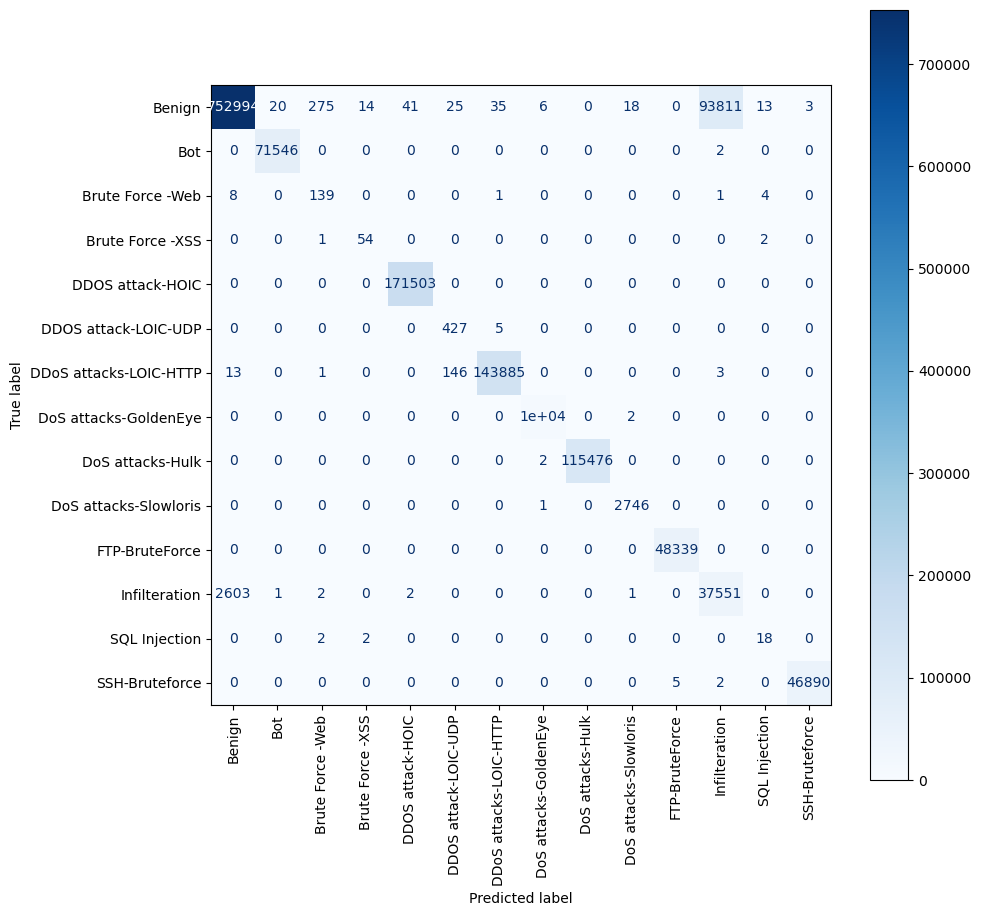

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from CustomFunctions import classification_report_IDS

#Output results
print('\nTraining Set: Size: ', X_train.shape)
print('Training Set: F2 score: ', fbeta_score(y_train, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')

#Plot the confusion matrix
c = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test), display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10,10))
c.plot(ax = ax, cmap='Blues', xticks_rotation='vertical')

## Classification Report
classification_report_IDS(y_test, pred_test)

In [23]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1158,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 152,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1,
 'max_bin': 400,
 'bagging_fraction': 0.807,
 'bagging_freq': 0}

## What is the optimum Training Set size?

In [28]:
from collections import Counter
Counter(y_train)

Counter({'DoS attacks-Hulk': 164962,
         'DDOS attack-HOIC': 156456,
         'DDoS attacks-LOIC-HTTP': 151250,
         'Bot': 129813,
         'Benign': 121965,
         'Infilteration': 120476,
         'SSH-Bruteforce': 84521,
         'DoS attacks-GoldenEye': 31131,
         'FTP-BruteForce': 29045,
         'DoS attacks-Slowloris': 8243,
         'DDOS attack-LOIC-UDP': 1298,
         'Brute Force -Web': 458,
         'Brute Force -XSS': 173,
         'SQL Injection': 65})

In [29]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

#Define the over sampling and under sampling dictionaries
dictUnderSample = { 'DoS attacks-Hulk': 70000,
                    'DDOS attack-HOIC': 70000,
                    'DDoS attacks-LOIC-HTTP': 70000,
                    'Bot': 70000,
                    'Benign': 70000,
                    'Infilteration': 70000,
                    'SSH-Bruteforce': 70000,
                    'DoS attacks-GoldenEye': 31131,
                    'FTP-BruteForce': 29045,
                    'DoS attacks-Slowloris': 8243,
                    'DDOS attack-LOIC-UDP': 1298,
                    'Brute Force -Web': 458,
                    'Brute Force -XSS': 173,
                    'SQL Injection': 65}

dictOverSample = {  'DoS attacks-Hulk': 70000,
                    'DDOS attack-HOIC': 70000,
                    'DDoS attacks-LOIC-HTTP': 70000,
                    'Bot': 70000,
                    'Benign': 70000,
                    'Infilteration': 70000,
                    'SSH-Bruteforce': 70000,
                    'DoS attacks-GoldenEye': 70000,
                    'FTP-BruteForce': 70000,
                    'DoS attacks-Slowloris': 70000,
                    'DDOS attack-LOIC-UDP': 70000,
                    'Brute Force -Web': 70000,
                    'Brute Force -XSS': 70000,
                    'SQL Injection': 70000}

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
print(len(X_train2))
y_train2.value_counts()

939045


Label
Benign                    70000
Bot                       70000
Brute Force -Web          70000
Brute Force -XSS          70000
DDOS attack-HOIC          70000
DDOS attack-LOIC-UDP      70000
DDoS attacks-LOIC-HTTP    70000
DoS attacks-GoldenEye     70000
DoS attacks-Hulk          70000
DoS attacks-Slowloris     70000
Infilteration             70000
SQL Injection             70000
SSH-Bruteforce            70000
FTP-BruteForce            29045
Name: count, dtype: int64

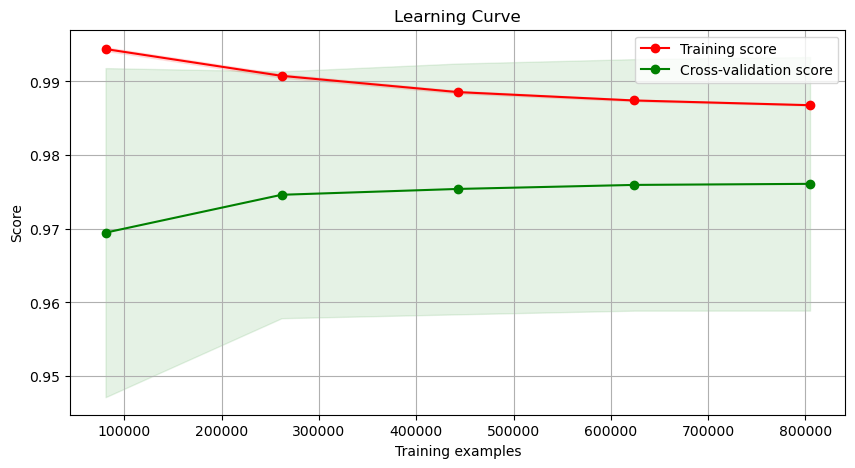

In [30]:
from plot_Validation_and_LearningCurves import plot_learning_curve, plot_validation_curve
from sklearn import metrics
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=7)
f2_scorer = make_scorer(fbeta_score, beta=2, average='macro')
plot_learning_curve(clf, X=X_train2, y=y_train2, cv=cv, scoring=f2_scorer, train_sizes=np.linspace(0.1, 1.0, 5));


**Observations:** The above Learning Curve seems to be ideal as both the training and validation curves are producing very high F2 scores while the gap between them is only 1% - indicating there is relatively low overfitting. Also, a good training set size would be around 500,000